In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from mod_my_utils.read_write_data import *

In [3]:
class Sto_osc:
    def __init__(self, folder_path='data/',stock_name='AAPL',index_col ='Date',period =200, buy_threshold=20,sell_threshold=80):
        self.period=period
        self.buy_threshold=buy_threshold
        self.sell_threshold= sell_threshold
        self.folder_path = folder_path
        self.stock_name = stock_name
        self.index_col = index_col

    def read_data(self):
        stock_data = get_price_csv(folder_name = self.folder_path, symbol = self.stock_name, index_col = self.index_col)
        data = stock_data[['Adj. Close']].copy()
        data.columns= ['price']
        data['Adj. High']=stock_data['Adj. High']
        data['Adj. Low']= stock_data['Adj. Low']
        data.tail(20)

        return data

    def sto_osc(self, data):
        data['highest_high'] = data['Adj. High'].rolling(window=self.period).max()
        data['lowest_low' ] = data['Adj. Low'].rolling(window=self.period).min()
        data['Stochastic Oscillator'] = 100*(data['price']- data['lowest_low'])/(data['highest_high']- data['lowest_low'])
        data['%d'] = data['Stochastic Oscillator'].rolling(window=3).mean()
        data[['Stochastic Oscillator', '%d']].plot()

        return data

    def buysell_signal(self,data):
        signals = pd.DataFrame(index= data.index)
        signals['price'] = data['price']
        signals['%K']=  data['Stochastic Oscillator']
        signals['%d'] = data['%d']
        signals['b']=0.0
        signals['buy']=0
        signals['sell']=0
        signals['s']=0.0
        signals['b']=np.where(data['Stochastic Oscillator']< self.buy_threshold, -1.0,0.0)
        signals['s']=np.where(data['%d']> self.sell_threshold, 1.0,0.0)
        signals['buy'] = signals['b'].diff()
        signals['sell'] = signals['s'].diff()
        signals.loc[signals['buy']==-1.0,['buy']] = 0
        signals.loc[signals['sell']== 1.0,['sell']] = 0
        signals['buy_sell'] = signals['buy'] + signals['sell']
        signals.head(50)

        return signals
    def KD_crossover(self,buysellsignal):
        KD = pd.DataFrame(index= buysellsignal.index)
        KD['price'] = buysellsignal['price']
        KD['K']=  buysellsignal['%K']
        KD['d'] = buysellsignal['%d']
        KD['b']=0.0
        KD['s']=0.0
        KD['b']=np.where(buysellsignal['%K']>buysellsignal['%d'], -1.0,0.0)
        KD['s']=np.where(buysellsignal['%K']<buysellsignal['%d'], 1.0,0.0)
        KD['buy'] = buysellsignal['b'].diff()
        KD['sell'] = buysellsignal['s'].diff()
        KD.loc[KD['buy']==-1.0,['buy']] = 0
        KD.loc[KD['sell']== 1.0,['sell']] = 0
        KD['buy_sell'] = KD['buy'] + KD['sell']
        #signals.head(50)
        KD['buy_sell'].plot()

        return KD

    def plot_signal(self,get_signal):

        graph = plt.figure(figsize=(30,12))
        ax1 = graph.add_subplot(211, ylabel= '%K')
        ax2 = graph.add_subplot(212,ylabel= 'price')

        get_signal['K'].plot(ax=ax1,title = 'Signals on K')

        ax1.axhline(y= self.buy_threshold, color = "m", lw = 2)
        ax1.axhline(y= self.sell_threshold, color = "g", lw = 2)
        ax1.plot(get_signal.loc[get_signal.buy_sell == 1].index, get_signal.K[get_signal.buy_sell == 1],"^", markersize = 12, color ='r')
        ax1.plot(get_signal.loc[get_signal.buy_sell == -1].index, get_signal.K[get_signal.buy_sell == -1],"v", markersize = 12, color ='b')

        get_signal['price'].plot(ax=ax2,title = 'Signals on price')

        ax2.plot(get_signal.loc[get_signal.buy_sell == 1].index, get_signal.loc[get_signal.buy_sell == 1].price,"^", markersize = 12, color ='r')
        ax2.plot(get_signal.loc[get_signal.buy_sell == -1].index, get_signal.loc[get_signal.buy_sell == -1].price,"v", markersize = 12, color ='b')


        plt.show()

    def optimize_parameters(self):
        # Define the parameter ranges for optimization
        # periods = [50, 100, 150, 200, 250]
        # buy_thresholds = [10, 20, 30, 40]
        # sell_thresholds = [60, 70, 80, 90]
        periods = [50, 100, 150]
        buy_thresholds = [10]
        sell_thresholds = [60]

        best_return = -np.inf
        best_params = None

        for period in periods:
            for buy_threshold in buy_thresholds:
                for sell_threshold in sell_thresholds:
                    # Instantiate the class with the current parameters
                    sto = Sto_osc(period=period, buy_threshold=buy_threshold, sell_threshold=sell_threshold)

                    # Fetch historical price data
                    data = sto.read_data()

                    # Calculate Stochastic Oscillator and buy/sell signals
                    data = sto.sto_osc(data)
                    signals = sto.buysell_signal(data)
                    kd_crossover = sto.KD_crossover(signals)

                    # Calculate the total return using the buy/sell signals
                    total_return = sto.calculate_total_return(signals)

                    # Update the best parameters if a better return is found
                    if total_return > best_return:
                        best_return = total_return
                        best_params = {'period': period, 'buy_threshold': buy_threshold, 'sell_threshold': sell_threshold}

                    return best_params, best_return

    def calculate_total_return(self, signals):
        if signals.empty or signals['buy_sell'].sum() == 0:
            return 1.0  # Return 1.0 if no buy/sell signals or the signals DataFrame is empty.

        # Simulate the trading strategy based on buy/sell signals and historical price data
        # For this example, we will assume a simple buy-and-hold strategy using the 'Adj. Close' price.
        data = self.read_data()
        signals['position'] = signals['buy_sell'].cumsum()
        signals['returns'] = data['price'].pct_change() * signals['position'].shift()
        total_return = (signals['returns'] + 1).cumprod()[-1]
        return total_return


stock name:  AAPL


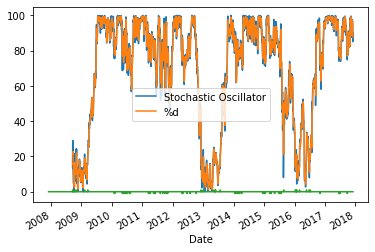

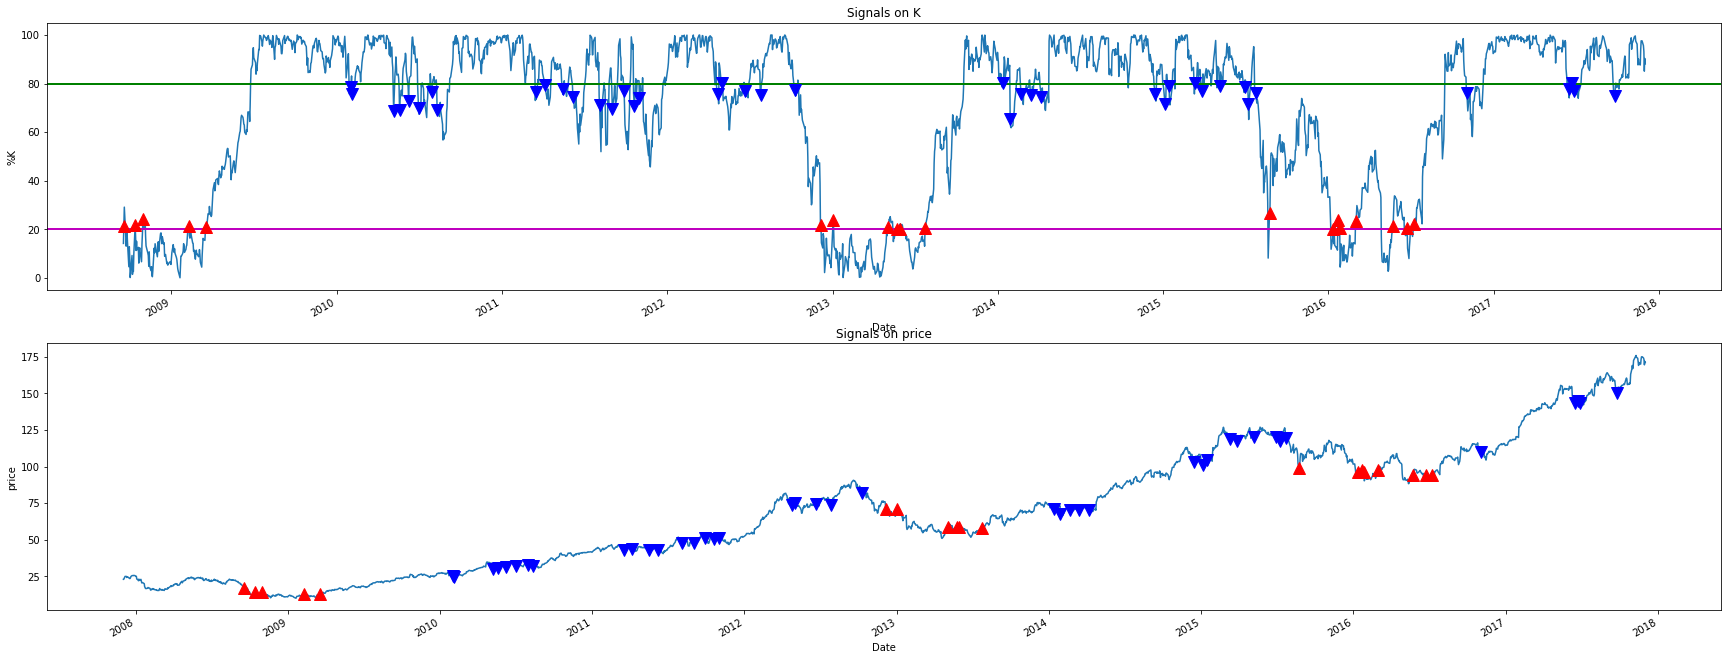

In [4]:
stochastic=Sto_osc()
data=stochastic.read_data()
dta= stochastic.sto_osc(data)
dt= stochastic.buysell_signal(dta)
d= stochastic.KD_crossover(dt)
stochastic.plot_signal(d)

stock name:  AAPL
stock name:  AAPL
Best Parameters: {'period': 50, 'buy_threshold': 10, 'sell_threshold': 60}
Best Return: 0.0006489127043225051


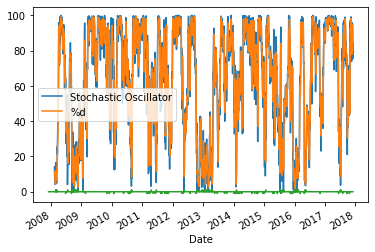

In [5]:
sto = Sto_osc()

    # Perform parameter optimization

best_params, best_return = sto.optimize_parameters()
print("Best Parameters:", best_params)
print("Best Return:", best_return)